In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_ratings = pd.read_csv('data/ratings.csv')
df_ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [3]:
df_ratings.shape

(5976479, 3)

In [4]:
df_ratings.user_id = df_ratings.user_id.astype('category').cat.codes.values # reassign everything between 0 and max
df_ratings.book_id = df_ratings.book_id.astype('category').cat.codes.values

In [5]:
df_ratings.head()

,user_id,book_id,rating
0,0,257,5
1,1,4080,4
2,1,259,5
3,1,9295,5
4,1,2317,3


In [6]:
from sklearn.model_selection import train_test_split # split 0.8 train set
train, test = train_test_split(df_ratings, test_size=0.2)

In [7]:
train.shape

(4781183, 3)

In [8]:
test.shape

(1195296, 3)

In [9]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_books = len(df_ratings.user_id.unique()), len(df_ratings.book_id.unique())
n_latent_factors = 3

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
book_input = keras.layers.Input(shape=[1],name='Item')
book_embedding = keras.layers.Embedding(n_books + 1, n_latent_factors, name='Movie-Embedding')(book_input)
book_vec = keras.layers.Flatten(name='FlattenMovies')(book_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

prod = keras.layers.merge([book_vec, user_vec], mode='dot',name='DotProduct')
model = keras.Model([user_input, book_input], prod)
model.compile('adam', 'mean_squared_error')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/usr/local/lib/python3.5/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         30003       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         160275      User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [15]:
history = model.fit([train.user_id, train.book_id], train.rating, epochs=100, verbose=0)

In [16]:
model.save('mf_model')

In [23]:
from keras.models import load_model
model = load_model('mf_model')

/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


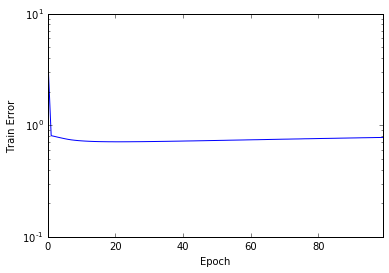

In [24]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
# plt.savefig('loss.jpg')

In [25]:
y_hat = np.round(model.predict([test.user_id, test.book_id]),0)
y_true = test.rating

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.6605301113699034

In [20]:
book_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(book_embedding_learnt).describe()

,0,1,2
count,10001.000000,10001.000000,10001.000000
mean,0.246390,0.064563,0.131827
std,0.085524,0.099693,0.106800
min,-0.330651,-0.438856,-0.324437
25%,0.206274,0.014759,0.080461
50%,0.250580,0.086667,0.140014
75%,0.294017,0.131660,0.194659
max,0.668678,0.488196,0.649525


In [21]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2
count,53425.000000,53425.000000,53425.000000
mean,9.896693,5.827342,6.585318
std,1.532017,3.235177,2.878489
min,0.026917,-11.259746,-10.124951
25%,8.903464,3.655142,4.682392
50%,9.889609,5.822628,6.672758
75%,10.872758,8.041405,8.601033
max,15.610165,19.546991,17.693632
